# Détection de plaques

Suite à un appel d’offre de la région Normandie, une société d’informatique de la région caen
naise vous propose de réaliser le prototype d’un système de reconnaissance de certains types
 de véhicules. Plus précisément, vous devez pouvoir détecter toute voiture qui circulent en ayant
 placé un gilet jaune sur le tableau de bord et relever son numéro de plaque qui sera ensuite
 transmis à un institut de sondage1
 Nous supposerons que le système de capture est capable de fournir trois images pour chaque
 voiture : une vue d’ensemble permettant de voir le conducteur et les passagers, une extraction
 du tableau de bord et une extraction de la plaque d’immatriculation

In [1]:
import cv2
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import rotate
from scipy.ndimage import median_filter
from skimage.transform import resize
from scipy.signal import find_peaks
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, morphology, measure, color

# Visualisation des données brutes

In [2]:
def get_image_gray(path):
    # Charger l'image
    image = io.imread(path)
    # Vérifier le nombre de canaux
    if len(image.shape) == 3:
        if image.shape[2] == 2:
            image_gray = np.min(image, axis=2).astype(np.uint8)
        elif image.shape[2] == 3 or image.shape[2] == 4:
            image_gray = np.min(image[..., :3], axis=2).astype(np.uint8)
        else:
            raise ValueError("L'image a un nombre de canaux inattendu.")
    else:
        image_gray = image.astype(np.uint8)
    return image_gray


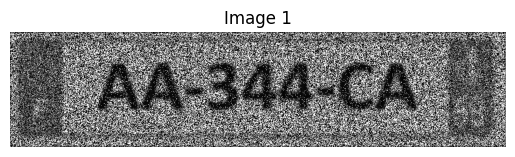

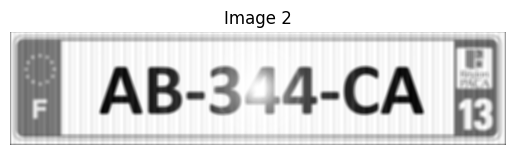

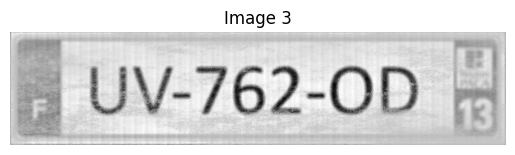

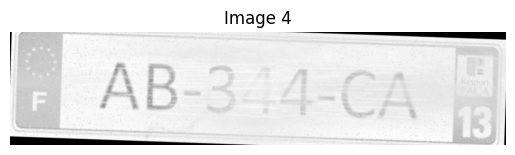

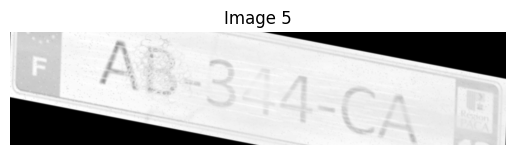

In [3]:
for i in range(1, 6):
    path_image = f'ressources/plaque-{i:03d}.png'
    im = get_image_gray(path_image)
    
    # Créer des variables dynamiquement pour pouvoir réutiliser ces images (im_1, im_2, etc) en dehors de la boucle for
        # On aurait pu faire autrement mais j'ai découvert ça pendant le TP donc je souhaitais l'utiliser
    globals()[f'im_{i}'] = im

    # Affichage des plagues brutes
    plt.figure()
    plt.title(f'Image {i}')
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()



# Détection des caractères

La méthode de **convolution** est un procédé utilisé en traitement d'image pour appliquer un filtre (ou noyau) à une image. Ce filtre peut être utilisé pour effectuer des tâches comme le flou, la détection de contours, ou même la reconnaissance de motifs. Dans notre cas, la convolution  sera utilisée pour comparer les caractères des plaques d'immatriculation avec un dictionnaire de lettres et de chiffres préalablement définis.

Voici un résumé de la méthode :

1. **Découpe de l'image** : L'image de la plaque d'immatriculation est d'abord découpée en régions représentant chaque caractère. Chaque caractère est isolé, ce qui permet de le traiter indépendamment.

2. **Convolution** : Pour chaque caractère découpé, on applique une opération de convolution entre l'image du caractère et un noyau (ou filtre) représentant les formes des caractères dans le dictionnaire. Ce noyau est une version de l'image d'un caractère que l'on veut reconnaître. La convolution consiste à déplacer ce noyau sur l'image du caractère et à calculer la similarité entre la fenêtre de l'image et le noyau à chaque position. Cela donne une mesure de la ressemblance à chaque point de l'image.

3. **Calcul de la différence** : La convolution génère une carte de similarité où les zones qui ressemblent le plus au caractère recherché auront une valeur élevée. En inversant cette mesure, on obtient une carte de différence. Cela permet de trouver quel caractère dans le dictionnaire est le plus similaire à celui découpé de l'image.

4. **Choix du meilleur match** : Le caractère pour lequel la différence entre l'image du caractère découpé et le noyau est la plus faible est considéré comme une correspondance. Ce caractère est alors "reconnu" et ajouté à la séquence de la plaque d'immatriculation.

# Construction des dictionnaires

In [4]:
# On s'assure que nos images de références pour nos caractères dans les dictionnaires soient bien en binaire
def get_car_binary(path):
    image_gray = get_image_gray(path)
    image_binary = image_gray > 100         # Seuil choissit arbitrairement mais marche bien avec toute la base de données des caractères
    return image_binary


# On souhaite redimensionner nos images en rognant parfaitement nos images sur les caractères (i.e. pas d'espace blanc autour)
def segmentation_colonne(image):
    start_colonne, end_colonne = None, None
    flag = 0
    # Segmenter par colonnes
    for colonne in range(image.shape[1]):
        has_black_pixel = np.any(image[:, colonne] == 0)
        if has_black_pixel and flag == 0:
            flag = 1
            start_colonne = colonne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_colonne = colonne
            if end_colonne - start_colonne >= 5:
                return image[:, start_colonne:end_colonne]
    return image # pas de segmentation trouvée


def segmentation_ligne(image):
    start_ligne, end_ligne = None, None
    flag = 0
    # Segmenter par lignes
    for ligne in range(image.shape[0]):
        has_black_pixel = np.any(image[ligne, :] == 0)
        if has_black_pixel and flag == 0:
            flag = 1
            start_ligne = ligne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_ligne = ligne
            # Vérifie que l'écart entre start_ligne et end_ligne est d'au moins 10 pixels
            if end_ligne - start_ligne >= 5:
                return image[start_ligne:end_ligne, :]
    return image  # Pas de segmentation trouvée


def segmentation_ligne_colonne(image):
    image_segmented_colonne = segmentation_colonne(image)
    return segmentation_ligne(image_segmented_colonne)


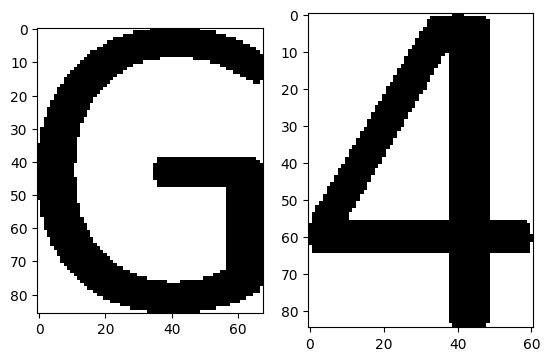

In [5]:
# Construction du dictionnaire des caractères utilisé pour la convolution
lettre_folder = 'ressources/lettres/'
chiffre_folder = 'ressources/chiffres/'

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
chiffre_list = '0123456789'

dictionnaire_lettre = {}
dictionnaire_chiffre = {}

# On ajoute les lettres au dictionnaire
for lettre in alphabet:
    dictionnaire_lettre[lettre] = segmentation_ligne_colonne(get_car_binary(lettre_folder + lettre + '.png'))

# On ajoute les chiffres au dictionnaire
for chiffre in chiffre_list:
    image_chiffre = get_car_binary(chiffre_folder + chiffre + '.png')
    image_chiffre_pre_segmented = image_chiffre[10:, 10:]
    dictionnaire_chiffre[chiffre] = segmentation_ligne_colonne(image_chiffre_pre_segmented)

# Affichage d'un exemple
plt.subplot(1, 2, 1)
plt.imshow(dictionnaire_lettre['G'], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dictionnaire_chiffre['4'], cmap='gray')
plt.show()

# Amélioration des images

In [6]:
# Fonction pour convertir l'image en binaire en fonction du seuil
def convert2binary(image_gray, seuil):
    return image_gray > seuil

# Fonction pour appliquer un filtre médian pour lisser l'image
def smooth_image_median(image):
    return median_filter(image, size=2)

# Fonction pour nettoyer l'image en supprimant les petits objets
def clean_image(image, min_size=50):
    return morphology.remove_small_objects(image, min_size=min_size)

# Fonction pour dilater l'image
def dilate_image(image, size=6):
    return morphology.dilation(image, morphology.square(size))

# Fonction pour combiner l'image dilatée et l'image nettoyée
def combine_images(cleaned_image, dilated_image):
    return np.logical_and(1 - dilated_image, 1 - cleaned_image)

# Fonction pour appliquer plusieurs dilatations à l'image
def apply_multiple_dilations(image, iterations=3):
    for _ in range(iterations):
        image = morphology.binary_dilation(image)
    return image

# Fonction pour extraire la région centrale de l'image
    # On s'intéresse uniquement à la partie contenant les caractères
def extract_central_region(image, lines=100, columns=700):
    total_columns = image.shape[1]
    total_lines = image.shape[0]
    start_line = (total_lines - lines) // 2
    end_line = start_line + lines
    start_column = (total_columns - columns) // 2
    end_column = start_column + columns

    return image[start_line:end_line, start_column:end_column]

def process_image(im, seuil=170, nb_iterations=3):
    im_bin = convert2binary(im, seuil)
    smoothed_image = smooth_image_median(im_bin)
    cleaned_image = clean_image(smoothed_image)
    dilated_image = dilate_image(cleaned_image)
    combined_image = combine_images(cleaned_image, dilated_image)
    final_image = apply_multiple_dilations(combined_image, iterations=nb_iterations)
    final_image = 1 - final_image
    image_centre = extract_central_region(final_image)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)  
    plt.title('image originale')
    plt.imshow(im, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)  
    plt.title('image filtrée')
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)  
    plt.title('image recentrée')
    plt.imshow(image_centre, cmap='gray')
    plt.axis('off')
    plt.show()

    return image_centre


# Segmentation de l'image + identification

In [7]:
# Fonction pour séparer les caractères sur une plaque en fonction d'un seuil de pixels noirs
def segmentation_image(image, seuil=0):
    # Calcul de l'histogramme des pixels noirs par colonne
    histogram = np.sum(image == 0, axis=0)
    
    # Affichage de l'histogramme
    plt.figure(figsize=(16, 3))
    plt.plot(histogram, color='black')
    plt.title('Histogramme des pixels noirs par colonne')
    plt.xlabel('Colonne')
    plt.ylabel('Nombre de pixels noirs')
    plt.grid(True)
    plt.show()
    
    # Segmentation des caractères
    liste_image_caractere = []  
    start_colonne = None
    flag = 0
    
    for colonne in range(image.shape[1]):
        has_black_pixel = histogram[colonne] > seuil  # Vérifie si le nombre de pixels noirs est au-dessus du seuil
        if has_black_pixel and flag == 0:
            flag = 1
            start_colonne = colonne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_colonne = colonne
            image_car = image[:, start_colonne:end_colonne]
            liste_image_caractere.append(image_car)
    
    # Si un caractère reste à la fin, on l'ajoute
    if flag == 1:
        image_car = image[:, start_colonne:]
        liste_image_caractere.append(image_car)
    
    return liste_image_caractere


def identify_character(image_unknown, index):
    # Initialiser les variables pour stocker la meilleure correspondance
    meilleur_score = -np.inf
    meilleur_caractere = None
    
    if index in {1, 2, 8, 9}:
        dictionnaire = dictionnaire_lettre
    elif index in {4, 5, 6}:
        dictionnaire = dictionnaire_chiffre
    else:
        return '-', None
    # Parcourir tous les caractères dans le dictionnaire
    for caractere, image_modele in dictionnaire.items():
        # Redimensionner l'image inconnue à la taille de l'image modèle
        image_resized = resize(image_unknown, image_modele.shape, mode='reflect', anti_aliasing=False, preserve_range=True)
        correspondance = np.sum(image_resized == image_modele)
        score = correspondance / image_modele.size
        if score > meilleur_score:
            meilleur_score = score
            meilleur_caractere = caractere
    
    return meilleur_caractere, meilleur_score

# Fonction pour afficher chaque caractère séparément et générer le nom de la plaque
def afficher_et_identification(image, seuil=10):
    # Séparation des caractères de l'image
    liste_image_caractere = segmentation_image(image, seuil)
    plaque = []
    
    # Affichage de chaque caractère séparé trouvé après l'identification
    plt.figure(figsize=(15, 3))
    
    for i, image_caractere in enumerate(liste_image_caractere):
        image_caractere = segmentation_ligne(image_caractere) 
        plt.subplot(1, len(liste_image_caractere), i + 1)
        plt.title(f'Caractère {i + 1}')
        plt.imshow(image_caractere, cmap='gray')
        
        # Identification du caractère
        meilleur_caractere, meilleur_score = identify_character(image_caractere, i + 1)
        plaque.append(meilleur_caractere)
    
    plt.tight_layout()
    plt.show()
    plaque[2] = '-'
    plaque[6] = '-'
    
    # Génération du nom de la plaque
    plaque_name = ''.join(plaque)
    print("Nom de la plaque : ", plaque_name)
    
    return plaque_name


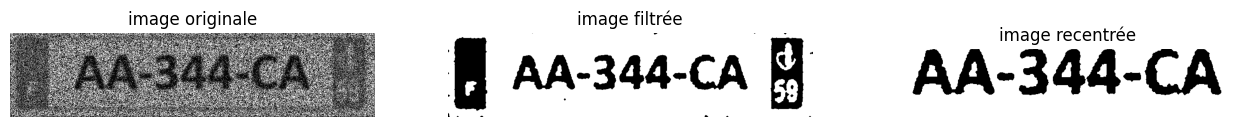

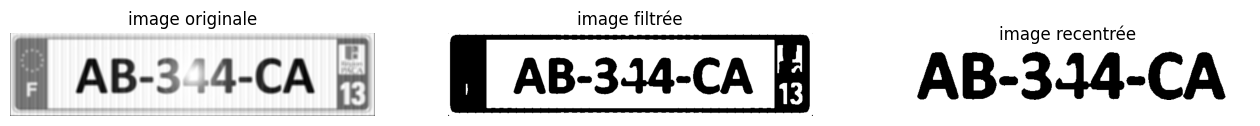

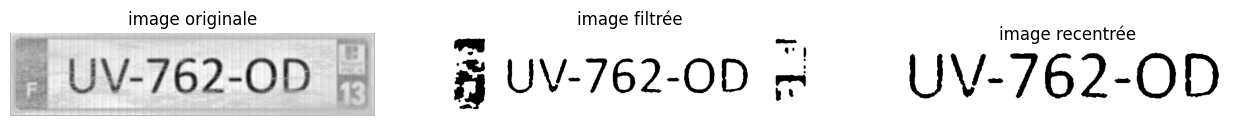

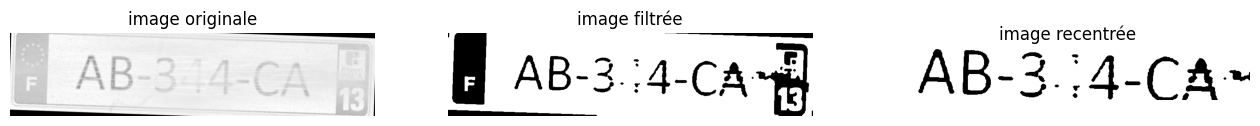

In [ ]:
im_centre_1 = process_image(im_1, nb_iterations=2)
im_centre_2 = process_image(im_2,seuil=230, nb_iterations=2)
im_centre_3 = process_image(im_3, nb_iterations=2)


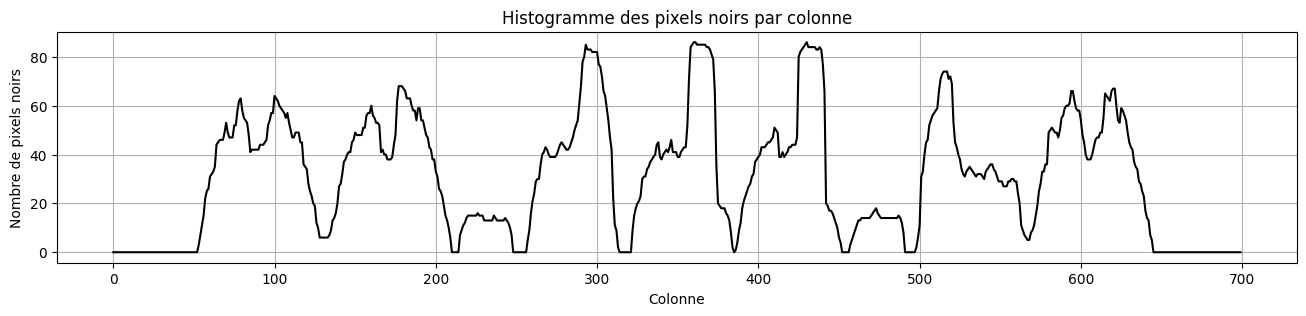

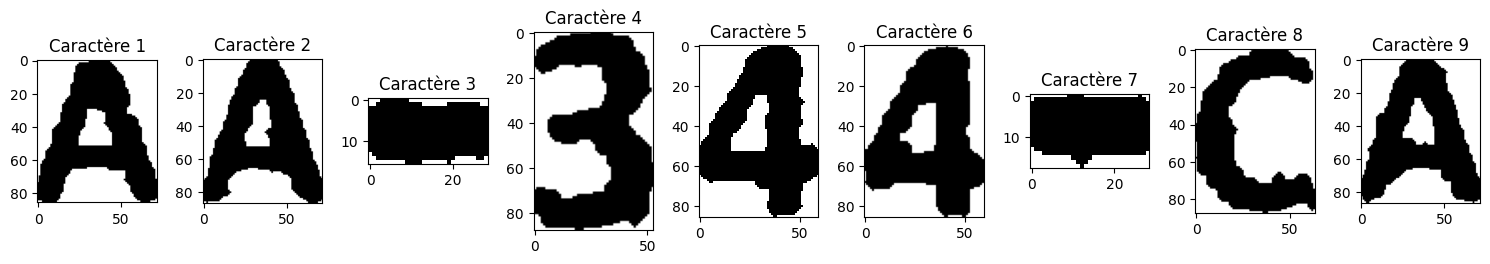

Nom de la plaque :  AA-344-CA


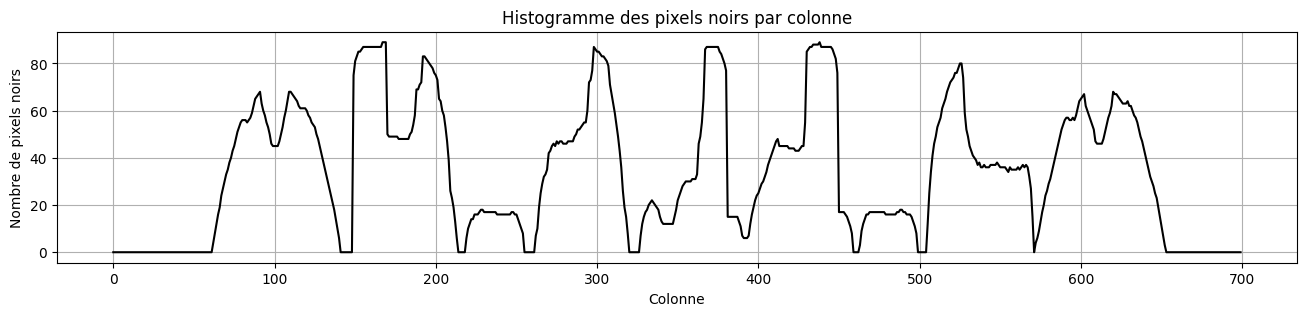

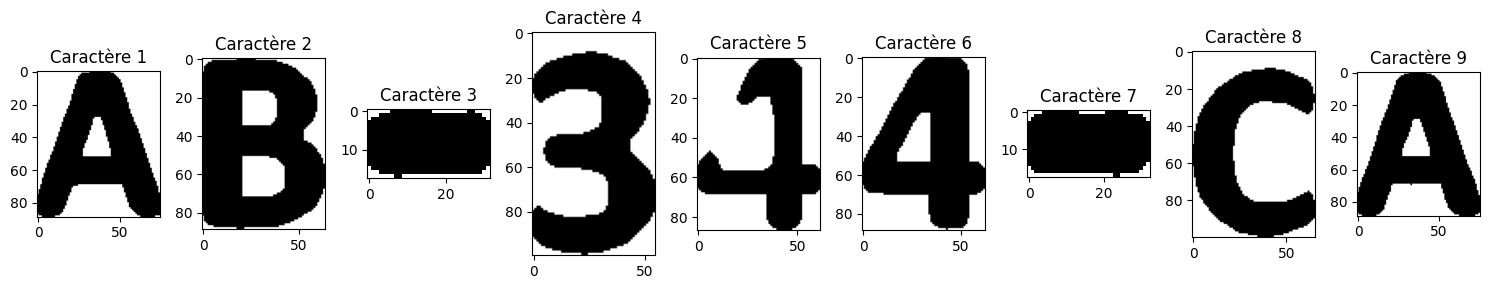

Nom de la plaque :  AB-344-CA


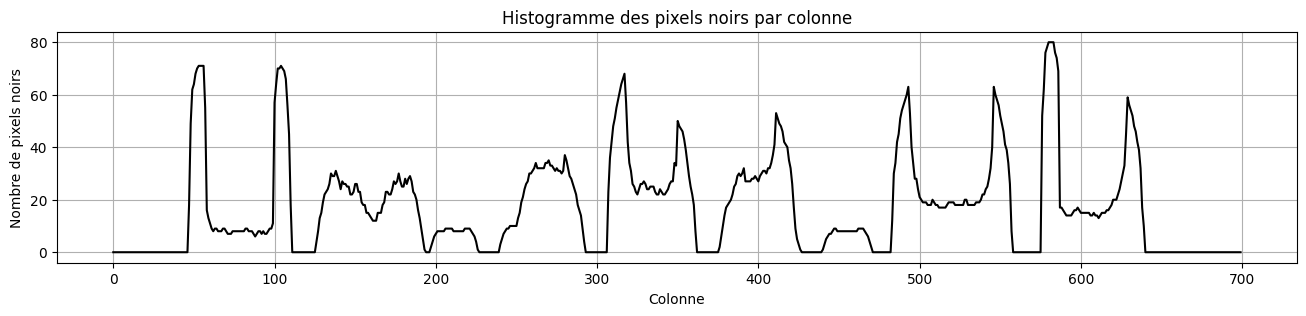

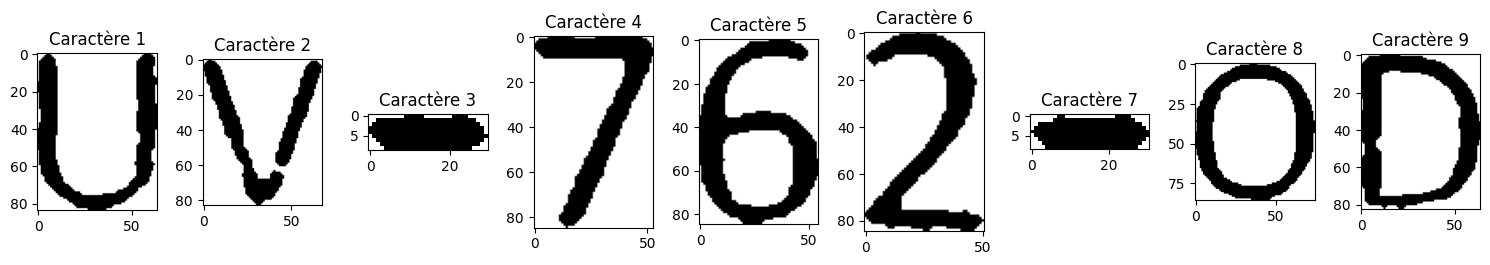

Nom de la plaque :  UV-762-OD


In [27]:
plaque_1 = afficher_et_identification(im_centre_1)
plaque_2 = afficher_et_identification(im_centre_2)
plaque_3 = afficher_et_identification(im_centre_3, seuil=0)

On constate que notre algorithme fonctionne étonnant bien : il identifie correctement les 3 premières plaques.
Il suffit de régler correctement le seuil pour convertir notre image en image binaire ainsi que le seuil pour la séparation des caractères à partir de la densité en pixel noir selon X de l'image. Ces deux seuils seraient facilement automatisable (par exemple, en forçant la détection de 10 'gros' symboles) mais nous avons préféré nous concentré sur la méthode utilisant de l'IA puis l'étude de cas n°2.

**Remarque :** Nous arions pu utiliser de nombreuses autres techniques pour le traitement d'image de nos plaques, par exemple en utilisant la FFT pour supprimer les artefacts périodiques comme on peut observer sur la plaque n°2.

# Correction de l'orientation des plaques

Contexte : Ici, les images sont **toujours** prises dans le même plan (X, Y), mais peuvent subir une rotation autour de l'axe Z. Cette variation d'orientation peut perturber les algorithmes de reconnaissance de caractères, car les lettres et chiffres peuvent être inclinés.

Pour résoudre ce problème, une approche consiste à rendre tous les pixels de l'image blancs, sauf les pixels noirs qui forment un rectangle (ou une forme similaire) autour de la plaque. Cela permet de visualiser les contours de la plaque, et ainsi de mesurer la pente de cette forme pour déterminer l'angle d'inclinaison.

Une fois l'angle d'inclinaison calculé, on peut appliquer l'angle opposé à l'image pour la remettre dans son orientation correcte, avant de procéder à la reconnaissance des caractères.



In [10]:
# Fonction pour trouver la ligne la plus basse de la colonne donnée
def trouver_ligne_basse_colonne(image, colonne):
    for ligne in range(image.shape[0] - 1, -1, -1):  
        if image[ligne, colonne] == 1:              
            return ligne
    return None  # Aucun pixel blanc trouvé

# Fonction pour obtenir l'orientation correcte de l'image
def get_correct_orientation(image_gray):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)  
    plt.title('image originale')
    plt.imshow(image_gray, cmap='gray')
    plt.axis('off')

    # Seuil pour binariser l'image
    im_bin = image_gray > 10  # Seuil très bas

    # Affichage de l'image binaire avant traitement
    plt.subplot(1, 3, 2)  
    plt.title('Image binaire utilisée pour la pente')
    plt.imshow(im_bin, cmap='gray')
    plt.axis('off')

    nb_colonnes = im_bin.shape[1]   # Nombre de colonnes de l'image
    delta = 10                      # Décalage pour éviter les bords

    # Définir les colonnes de départ et d'arrivée
    colonne_end = (nb_colonnes // 2) - delta
    colonne_start = delta

    # Calcul de l'angle de rotation
    ligne_start = trouver_ligne_basse_colonne(im_bin, colonne_start)
    ligne_end = trouver_ligne_basse_colonne(im_bin, colonne_end)

    if ligne_start is None or ligne_end is None:
        print("Erreur : Ligne non trouvée pour l'une des colonnes")
        return image_gray           # Retourner l'image originale en cas d'erreur

    # Calcul des différences pour déterminer l'angle
    y = ligne_start - ligne_end     # Différence en y (verticale)
    x = colonne_start - colonne_end # Différence en x (horizontale)
    
    # Calcul de l'angle en degrés
    angle = math.atan2(y, x) * 180 / np.pi + 180
    
    # Rotation de l'image
    im_rot = rotate(image_gray, angle, mode='constant', cval=1)

    plt.subplot(1, 3, 3)  
    plt.title('Après Rotation')
    plt.imshow(im_rot, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return im_rot

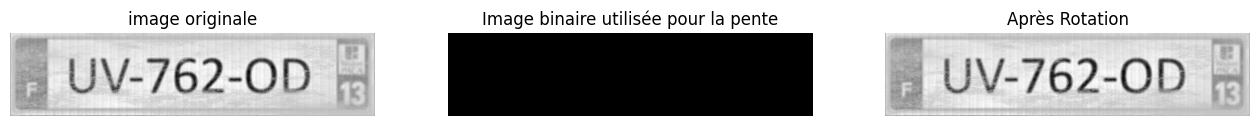

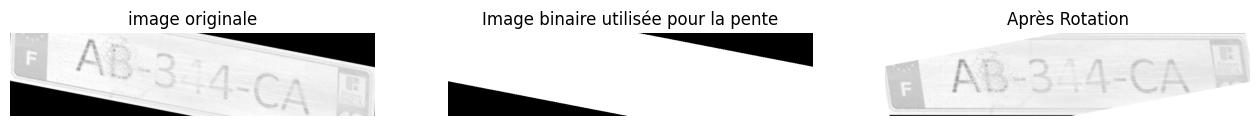

In [11]:
# Test sur une image qui a déjà la bonne orientation
im_rot = get_correct_orientation(im_3)
# Test sur une image qui nécessite une correction
im_rot = get_correct_orientation(im_5)

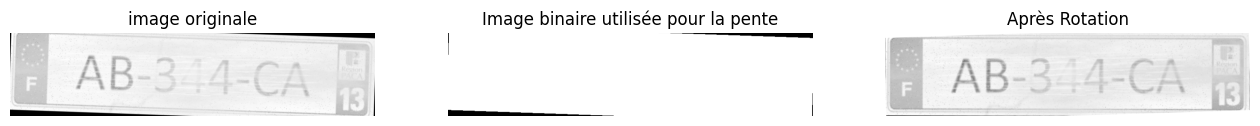

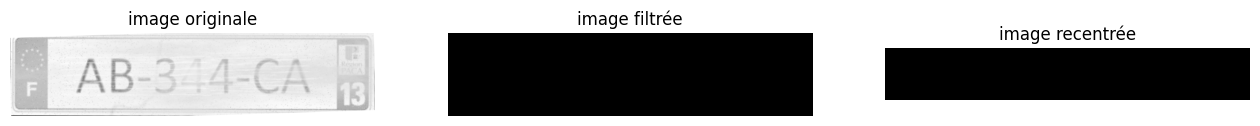

In [43]:
im_centre_4 = process_image(get_correct_orientation(im_4), seuil=10, nb_iterations=2)

# Début IA

Nous cherchons à générer des plaques d'immatriculation de manière aléatoire afin de constituer une base de données suffisamment large pour entraîner un modèle d'intelligence artificielle. Pour améliorer la robustesse du modèle, nous veillerons à ajouter du bruit, des distorsions et d'autres variations aux plaques synthétiques, simulant ainsi les conditions réelles d'acquisition des images. Cette approche permettra d'obtenir un modèle plus performant et mieux adapté aux différentes situations rencontrées en pratique.

In [12]:
def concat_images(image_1, image_2, nb_colonne=2):    
    """Concatène deux images horizontalement avec un léger recadrage."""
    if image_1.shape[0] != image_2.shape[0]:
        raise ValueError("Les images doivent avoir la même hauteur pour être concaténées horizontalement.")
    return np.concatenate((image_1[:, :-nb_colonne], image_2[:, nb_colonne:]), axis=1)

def add_border(image, border_size=5):
    """Ajoute un cadre blanc autour de l'image."""
    h, w = image.shape
    bordered_image = np.ones((h + 2 * border_size, w + 2 * border_size))  # Fond blanc (valeurs à 1)
    bordered_image[border_size:-border_size, border_size:-border_size] = image  # Insertion de l'image au centre
    return bordered_image

def add_gaussian_noise(image, mean=0, std_range=(100, 400)):
    """Ajoute un bruit gaussien d'intensité aléatoire à l'image."""
    std = random.uniform(*std_range)
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255)  # Assurer que les valeurs restent dans l'intervalle valide

def get_random_car(chaine):
    """Retourne un caractère aléatoire d'une chaîne donnée."""
    return random.choice(chaine)

def get_new_plaque():
    """Génère une plaque d'immatriculation aléatoire sous forme d'image et son texte associé."""
    path_tiret = "ressources/symboles/-.png"
    image_tiret = get_image_gray(path_tiret)

    plaque_nom = ''.join([
        get_random_car(alphabet), get_random_car(alphabet), '-', 
        get_random_car(chiffre_list), get_random_car(chiffre_list), get_random_car(chiffre_list), '-', 
        get_random_car(alphabet), get_random_car(alphabet)
    ])

    elements = [get_image_gray(lettre_folder + c + '.png') if c.isalpha() 
                else get_image_gray(chiffre_folder + c + '.png') if c.isdigit() 
                else image_tiret for c in plaque_nom]

    plaque_image = elements[0]
    for img in elements[1:]:
        plaque_image = concat_images(plaque_image, img)

    plaque_image = add_border(plaque_image, border_size=5)

    # Ajout du bruit gaussien avec une probabilité de 50%
    if random.random() < 0.5:
        plaque_image = add_gaussian_noise(plaque_image)

    return plaque_image, plaque_nom

JW-744-DQ


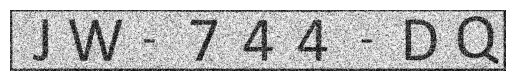

ST-109-XZ


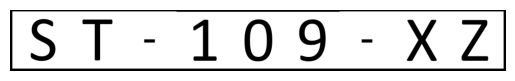

ZL-095-VF


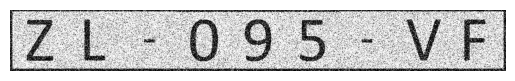

PR-423-UN


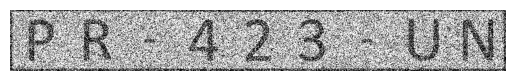

CQ-698-DQ


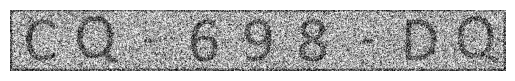

AE-982-XG


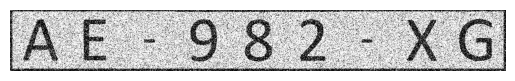

XW-846-KB


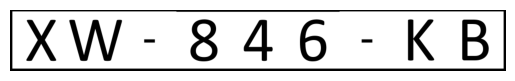

LF-983-FP


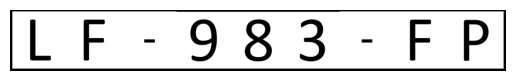

FL-832-GF


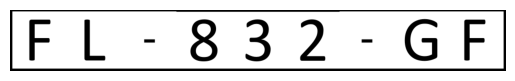

KG-814-MX


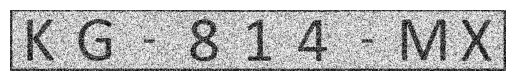

In [13]:
# Génération et affichage de 10 plaques d'immatriculation aléatoires
for _ in range(10): 
    plaque_image, plaque_nom = get_new_plaque()     # Générer une plaque
    print(plaque_nom)                               # Afficher la plaque générée
    plt.imshow(plaque_image, cmap='gray')
    plt.axis('off') 
    plt.show()

# Détection pour des photos prises avec un smartphone (i.e. photo couleur, orientation et distance aléatoires ...) 

Pour ce faire, on décide d'utiliser les deux rectangles bleus présents sur toutes les plaques d'immatriculations françaises.
Ces deux rectangles doivent nous permettre de détecter la présence d'une plaque. Pour ce faire, on décide de passer par l'espace HSV. En effet, on a constater par un heureux hasard que ces deux rectangles bleus ressortait particulièrement bien dans cet espace de couleur

In [14]:
def convert_to_hsv(image):
    hsv_image = color.rgb2hsv(image)
    return hsv_image


def filter_blue_hsv(hsv_image, lower_hue=0.55, upper_hue=0.8):
    hue_mask = (hsv_image[..., 0] >= lower_hue) & (hsv_image[..., 0] <= upper_hue)
    filtered_image = np.copy(hsv_image)
    filtered_image[~hue_mask] = 0  
    return filtered_image


def detect_edges_fft(image):
    # Appliquer FFT sur l'image
    gray_image = color.rgb2gray(image)
    fft_image = fftshift(fft2(gray_image))

    # Création d'un masque pour supprimer les basses fréquences
    rows, cols = gray_image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.uint8)
    r = 9
    mask[crow-r:crow+r, ccol-r:ccol+r] = 0
    fft_image_filtered = fft_image * mask
    
    image_back = np.abs(ifft2(fftshift(fft_image_filtered)))
    return image_back


def plot_contour_density_filtered_image(filtered_image):
    # Détecter les contours sur l'image filtrée
    contours = measure.find_contours(filtered_image, level=0.5)

    # Extraire les positions x et y de tous les contours
    all_x = np.concatenate([contour[:, 1] for contour in contours])
    all_y = np.concatenate([contour[:, 0] for contour in contours])

    # Créer des histogrammes pour la densité selon x et y
    hist_x, bins_x = np.histogram(all_x, bins=50)
    hist_y, bins_y = np.histogram(all_y, bins=50)

    # Trouver les deux pics principaux dans l'axe x
    peaks_x, _ = find_peaks(hist_x, height=np.max(hist_x) * 0.8)  # On considère les pics significatifs
    if len(peaks_x) >= 2:
        x1 = bins_x[peaks_x[0]]
        x2 = bins_x[peaks_x[1]]
    else:
        x1, x2 = bins_x[0], bins_x[-1]  # Valeurs par défaut si les pics ne sont pas trouvés correctement

    # Trouver la zone principale dans l'axe y (en utilisant une densité cumulée)
    cumsum_y = np.cumsum(hist_y)
    cumsum_y_norm = cumsum_y / cumsum_y[-1]  # Normaliser entre 0 et 1
    y1_idx = np.argmax(cumsum_y_norm > 0.1)  # 10% du cumul pour début de la zone
    y2_idx = np.argmax(cumsum_y_norm > 0.95)  # 90% du cumul pour fin de la zone
    y1 = bins_y[y1_idx]
    y2 = bins_y[y2_idx]

    # Afficher les histogrammes et les valeurs extraites
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # Densité selon l'axe x
    axs[0].hist(all_x, bins=bins_x, color='blue', alpha=0.7)
    axs[0].set_title("Densité des contours selon l'axe X")
    axs[0].set_xlabel("Position X")
    axs[0].set_ylabel("Nombre de contours")
    axs[0].axvline(x1, color='red', linestyle='--', label=f'x1={x1:.2f}')
    axs[0].axvline(x2, color='red', linestyle='--', label=f'x2={x2:.2f}')
    axs[0].legend()

    # Densité selon l'axe y
    axs[1].hist(all_y, bins=bins_y, color='green', alpha=0.7)
    axs[1].set_title("Densité des contours selon l'axe Y")
    axs[1].set_xlabel("Position Y")
    axs[1].set_ylabel("Nombre de contours")
    axs[1].axvline(y1, color='red', linestyle='--', label=f'y1={y1:.2f}')
    axs[1].axvline(y2, color='red', linestyle='--', label=f'y2={y2:.2f}')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return x1, x2, y1, y2


def add_green_bounding_boxes(image, contour_image):
    # Convertir l'image originale en RGB si elle est en HSV
    if image.shape[-1] == 3 and np.max(image) <= 1:
        image_rgb = color.hsv2rgb(image)
        image_rgb = (image_rgb * 255).astype(np.uint8)  # Revenir à l'échelle [0, 255]
    else:
        image_rgb = image
    
    # Convertir l'image en BGR pour l'affichage via OpenCV (car OpenCV utilise BGR)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    # Détection des contours dans l'image filtrée
    contours = measure.find_contours(contour_image, level=0.5)

    # Dessiner tous les contours en vert
    for contour in contours:
        # Convertir les points de contour en entiers
        contour = contour.astype(int)
        # Boucler sur les points du contour et tracer le contour
        for i in range(len(contour) - 1):
            pt1 = tuple(contour[i][::-1])  # (col, row) inversé pour (x, y)
            pt2 = tuple(contour[i + 1][::-1])
            cv2.line(image_bgr, pt1, pt2, (0, 255, 0), 2)  # Vert

    # Afficher les graphes de densité et obtenir les points (x1, x2, y1, y2)
    x1, x2, y1, y2 = plot_contour_density_filtered_image(contour_image)

    # Dessiner un rectangle rouge avec les points x1, x2, y1, y2
    cv2.rectangle(image_bgr, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

    # Convertir de nouveau en RGB pour l'affichage avec Matplotlib
    image_rgb_final = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Afficher l'image avec les contours verts et le rectangle rouge
    plt.figure(figsize=(4, 3))
    plt.imshow(image_rgb_final)
    plt.title("Image orignale avec la détection de la zone d'intérêt")
    plt.axis('off')
    plt.show()

    return image_rgb_final

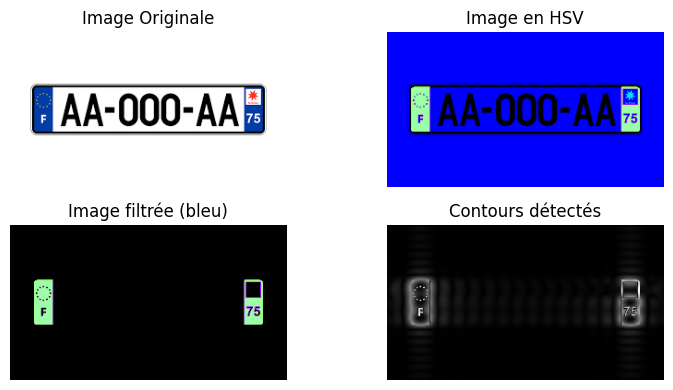

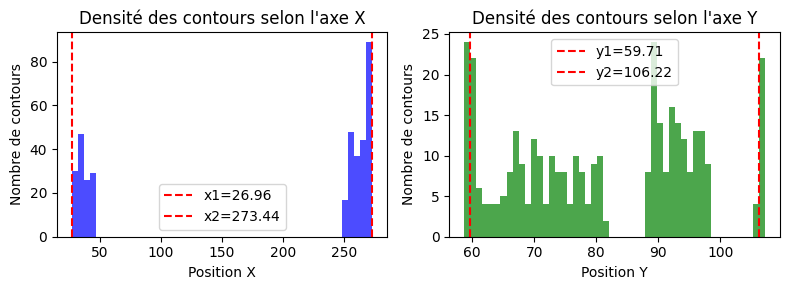

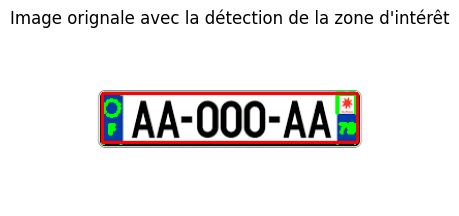

In [15]:

# Chargement de l'image
path = 'ressources/plaque_couleur.png'
plaque_couleur = io.imread(path)

hsv_plaque_couleur= (plaque_couleur)

# Affichage des images en 2x2
plt.figure(figsize=(8, 4))

# Affichage de l'image originale
plt.subplot(2, 2, 1)
plt.imshow(plaque_couleur)
plt.title('Image Originale')
plt.axis('off')

# Conversion en HSV
hsv_image = convert_to_hsv(hsv_plaque_couleur)
plt.subplot(2, 2, 2)
plt.imshow(hsv_image)
plt.title('Image en HSV')
plt.axis('off')

# Filtrage des niveaux de bleu
filtered_image = filter_blue_hsv(hsv_image)
plt.subplot(2, 2, 3)
plt.imshow(filtered_image)
plt.title('Image filtrée (bleu)')
plt.axis('off')

# Détection de contours avec FFT
edges_image = detect_edges_fft(filtered_image)
plt.subplot(2, 2, 4)
plt.imshow(edges_image, cmap='gray')
plt.title('Contours détectés')
plt.axis('off')

# Affichage de la grille
plt.tight_layout()
plt.show()

# Appliquer l'encadrement rouge autour de tous les contours détectés
final_image_with_single_box = add_green_bounding_boxes(plaque_couleur, edges_image)


Méthode qui fonctionne pour une image partfaite comme utilisée précédemment, or lorsque l'on utilise une image prise par un smartphone, les reflets viennent perturbés le traitement de l'image dans l'espace HSV ==> méthode inutilisable en fin de compte